-------
# 1. 라이브러리 불러오기

---------

In [2]:
import nltk
nltk.download('stopwords')
import tensorflow
import summa


import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---------
# 2. 데이터 수집하기
---------

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


데이터프레임의 이름을 변경 

In [5]:
data.rename(columns = {'headlines':'summary'},inplace = True)

In [6]:
data.head()

,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련

---------
# 3. 데이터 전처리

----------

In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# 중복 샘플 제거 
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
# 남아있는 null값 확인
print(data.isnull().sum())

summary    0
text       0
dtype: int64


In [10]:
# 약어 확인
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 확인 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

전처리를 위한 함수 생성

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

샘플 뽑아서 전처리가 잘 이루어 지는지 확인

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


--------
### 3-1. text 부분 전처리 

--------

In [14]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

--------
### 3-2. summary부분 전처리

--------

In [15]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 
for s in data['summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
data = pd.DataFrame() 

In [17]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [18]:
# null값 확인 
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [19]:
data['Text'].shape

(98360,)

--------
# 4. 데이터 나누기

--------

데이터의 길이 및 분포 그래프로 확인 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


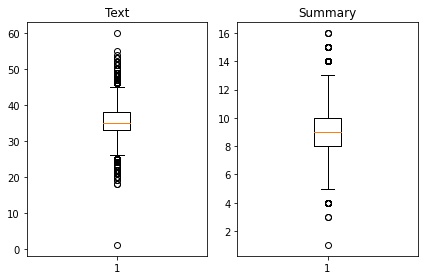

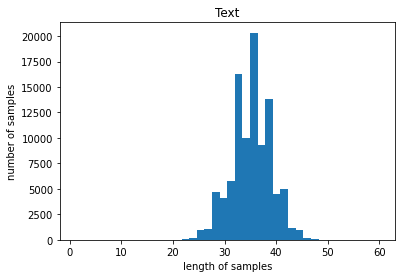

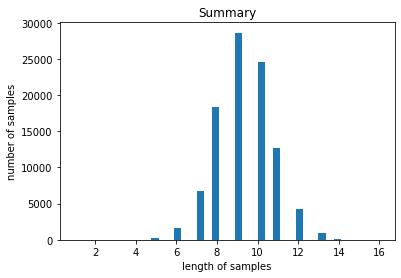

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 내용을 보면 text의 중간값은 35 / summary의 중간값은 9 정도가 된다.

text는 25 ~ 45 정도까지 분포를 보이고 있으며   
summary는 6 ~ 13 정도 까찌 분포를 보이고 있다.

데이터셋 자체가 중복값이나 null값이 없는 것으로 보아 정제가 잘 된 데이터셋이라고 판단하고 최소한의 값만 제외한 후 모델에 학습을 진행하도록 하겠다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
# text와 summary의 최대길이를 임의로 설정
text_max_len = 43
summary_max_len = 12


In [ ]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


정해진 길이(43 or 12)보다 길거나 작으면 제외

In [ ]:
# 약 400여개 제외
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95935


시작점과 끝점을 붙인 데이터를 데이터프레임 안에 형성

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india recorded lowest odi total new zealand ge...,india get all out for their lowest odi total i...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [ ]:
# numpy타입으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[67904 65695 82905 ... 53674 60140 82353]


In [ ]:
# 데이터의 샘플 순서 재정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 데이터 8대2로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19187


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

# 이로 인해 단어의 집합은 src_tokenizer.word_index에 저장되어 있음 

토크나이저의 값을 확인

In [ ]:
# 단어 사전이 어떻게 구축 되어 있는지 확인
for idx in src_tokenizer.index_word:
    print(idx, ":", src_tokenizer.index_word[idx])

    if idx >= 10: break

1 : said
2 : india
3 : year
4 : added
5 : us
6 : also
7 : government
8 : first
9 : police
10 : people


등장 빈도가 5회 이하인 희귀단어를 확인해 보니 전체의 3% 정도밖에 되지 않으니 제외

In [ ]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68508
등장 빈도가 5번 이하인 희귀 단어의 수: 44863
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23645
단어 집합에서 희귀 단어의 비율: 65.48578268231448
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.137444634644522


In [ ]:
src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 23,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[820, 429, 9485, 7546, 1194, 3353, 2525, 1883, 523, 1949, 331, 1103, 232, 19181, 523, 1883, 7546, 1, 124, 4386, 2702, 29, 44, 105, 523, 717, 68, 1889, 1702, 17235, 560, 331], [53, 26, 9, 3, 13, 36, 85, 57, 871, 3, 13, 422, 7899, 6590, 562, 602, 43, 40, 108, 422, 2667, 8844, 161, 3695, 1578, 11100, 372, 2151, 5281, 553], [2272, 541, 230, 305, 196, 80, 54, 10, 252, 1968, 2287, 780, 4387, 12353, 14593, 11662, 70, 10, 1362, 426, 1596, 11662, 233, 1439, 1950, 1291, 11662, 14593, 1, 2776]]


In [ ]:
# summary도 동일하게 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

summary에서도 등장 빈도가 5회 이하인 희귀단어를 확인해 보니 전체의 4% 정도밖에 되지 않으니 제외

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29729
등장 빈도가 5번 이하인 희귀 단어의 수: 19445
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10284
단어 집합에서 희귀 단어의 비율: 65.40751454808436
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.739559906177019


In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1(sostoken/eostoken)인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 후 삭제

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


패딩하기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 5. 모델 설계하기

##### Embedding Layer
- ([단어 사전의 크기],[출력의 차원].[Input_length])
  - 단어 사전의 크기: 학습하고자 하는 단어의 수와 크기가 동일해야 함  
  - Input_length: 한 번에 학습하고자 하는 문장의 길이  
    다음에 플레튼 레이어가 오게되면 반듯이 명시 
    
##### LSTM
- input값을 받으면 hidden state와 cell state를 가진다.
- return_sequences와 return_state가 Flase일 경우 마지막 hidden state만 출력
- return_sequences = True로 설정할 경우 각 time step별 hidden state를 모두 출력 (attention을 사용하기 위함)
- return_state = True 를 한 경우에는 마지막 time step에서의 output(hidden state), hidden state와 cell state가 출력된다.  
  즉 마지막 output값이 2번 출력이 되고 cell state가 나온다.
- return_sequences와 return_state를 모두 True로 하게 되면 각 time step별 hidden state와 마지막 hidden state, 마지막 cell state 값이 출력

참고 블로그[https://simpling.tistory.com/19]

---------
### 5-1 인코더 설계

---------

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

---------
### 5-2 디코더 설계

---------

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 43, 128)      2944000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 43, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

---------
### 5-3 어텐션 매커니즘 설계

---------

##### summary 설명
- Layer(type) :  
레이어의 이름과 타입을 나타냅니다. 알아서 레이어의 이름을 지정해줍니다. 따로 지정해주고 싶을때는 Dense에 파라미터로 name='지정하고싶은 이름'을 주면 됩니다. dense_1, dense_2, dense_3 이라고 이름 붙여진 3개의 Dense레이어가 생성된 것을 볼 수 있습니다.  
 
- Output Shape:  
(None, 5)이라는 뜻은 None개의 행과 5개의 아웃풋 값이 주어졌다는 것을 뜻합니다. 행이 None으로 지정되는 이유는 데이터의 갯수는 계속해서 추가될 수 있기 때문에 딥러닝 모델에서는 주로 행을 무시하고 열의 shape을 맞추어주는 작업을 많이 수행합니다. 첫번째 레이어의 아웃풋 갯수는 5, 두번째 레이어의 아웃풋 갯수는 3, 마지막 레이어의 아웃풋 갯수는 1임을 뜻합니다.  
 
- Param:  
파라미터의 수, 즉 각 입력노드와 출력노드에 대해 연결된 간선의 수를 뜻합니다.  
첫번째 레이어는 인풋이 1개, 아웃풋이 5개 이므로 1x5=5개의 간선이 존재해야 하는데 10개의 간선이 있다고 표시되어 있습니다. 이유는 무엇일까요? 바로 인풋에 Bias(b) 노드가 추가되기 때문입니다.
따라서 첫번째 레이어에는 입력값(1)+바이어스노드(1)=2 총 2개의 인풋 노드가 있으므로 파라미터의 갯수는 2*5로 10개가 되는 것입니다.


참고 블로그 [https://ebbnflow.tistory.com/124]

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 43, 128)      2944000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 43, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

전체 레이어의 구조를 그래프로 표현

인코딩 부분에 LSTM층이 3개 디코딩 부분에 LSTM층과 1개와 Dense 층이 있는 모델을 설계

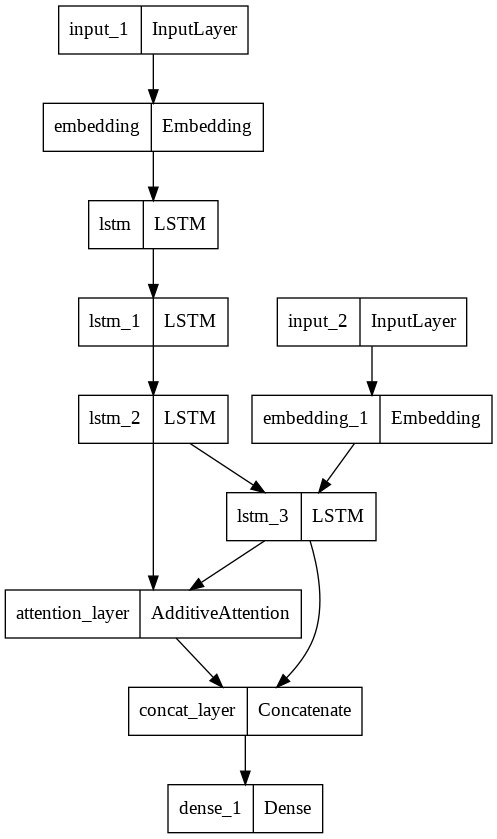

In [ ]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 38s 98ms/step - loss: 5.6289 - accuracy: 0.2812 - val_loss: 5.2011 - val_accuracy: 0.3051
Epoch 2/50
300/300 [==============================] - 27s 91ms/step - loss: 5.0311 - accuracy: 0.3101 - val_loss: 4.8099 - val_accuracy: 0.3237
Epoch 3/50
300/300 [==============================] - 27s 92ms/step - loss: 4.6872 - accuracy: 0.3264 - val_loss: 4.5447 - val_accuracy: 0.3392
Epoch 4/50
300/300 [==============================] - 27s 92ms/step - loss: 4.4339 - accuracy: 0.3415 - val_loss: 4.3731 - val_accuracy: 0.3510
Epoch 5/50
300/300 [==============================] - 27s 91ms/step - loss: 4.2273 - accuracy: 0.3555 - val_loss: 4.2341 - val_accuracy: 0.3621
Epoch 6/50
300/300 [==============================] - 27s 91ms/step - loss: 4.0547 - accuracy: 0.3678 - val_loss: 4.1194 - val_accuracy: 0.3707
Epoch 7/50
300/300 [==============================] - 27s 91ms/step - loss: 3.9081 - accuracy: 0.3788 - val_loss: 4.0368 - val_accuracy:

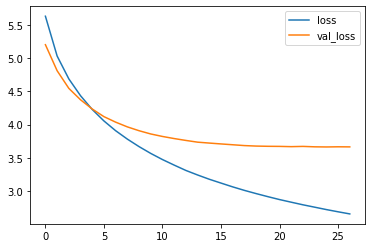

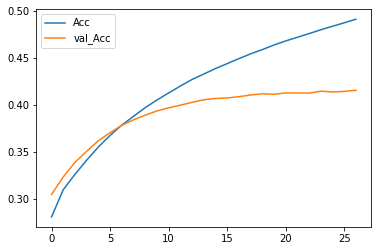

In [ ]:
# 시각화 
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='val_Acc')
plt.legend()
plt.show()

- val_loss가 3.6650 / val_accuracy가 0.4158로 나왔다. 
- loss는 감소하고 있지만 epoch이 늘어날 수록 val_loss의 감소폭이 줄어드는 모습을 보이고 있다.   
  아마도 과적합으로 인해 위와 같은 그래프가 나온것 같다.

- 위 모델은 Total params가 11,193,360개를 가지고 있어서 경량화를 통해 과적합을 줄여보고자 한다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
# 테스트 데이터 10개의 샘플에 대해서 실제 요약과 예측돤 요약 비교
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : survivor maharashtra elphinstone station stampede said crowd mistook vendor phool gir gaya comment gir gaya survivor said might caused stampede senior railway official stated yet ascertain sole cause mishap 
실제 요약 : mob gir gaya as maha stampede survivor 
예측 요약 :  maha cops set up to death for building


원문 : according international wine spirits research forecast india would among biggest global whisky market growth next five years india currently largest growth market whisky consumption scotch local rise notably three indian among global top spirit brands volume sales 
실제 요약 : india to be among top to whisky growth report 
예측 요약 :  fy ranked among world largest


원문 : stating ailing goa cm manohar parrikar defence minister rafale deal congress leader reddy asked blackmailing pm narendra modi keep chair cm need think reddy claimed parrikar sticking chair like addressing congress rally seeking resumption governance 
실제 요약 : is parrikar blackmailing pm modi to retain cm seat congres

요약을 잘 했는지 테스트 해보기 위해 10개를 뽑아보았다.  
실제 요약과 예측 요약의 괴리가 아직 있는 것 같다.

----------
# 6. 경량화를 위한 딥러닝 레이어 변경하기

---------

- 이전 레이어는 인코딩 부분에 LSTM Layer가 3개 디코딩 부분에 LSTM 레이어가 1개가 존재해 약 1100만개의 params가 존재한다. 

- 해당 모델이 무겁다는 전제하에 경량화를 통해 성능을 올려보려 한다. 

- 아래 딥러닝 레이어에는 인코딩 부분에 LSTM을 2개만 두며, recurrent_dropout까지 같이 사용해서 경량화를 해보겠다.

- 추가적으로 optimizer를 Adam으로 변경 및 learning_rate를 기존 디폴트값인 1에서 0.01로 설정하고 모델을 학습시켜보겠다.


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.1, recurrent_dropout = 0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


# 인코더의 LSTM 2
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output1)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 43, 128)      2944000     ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 43, 256),    394240      ['embedding_2[0][0]']            
                                 (None, 256),                                               

변경한 레이어 그래프로 확인

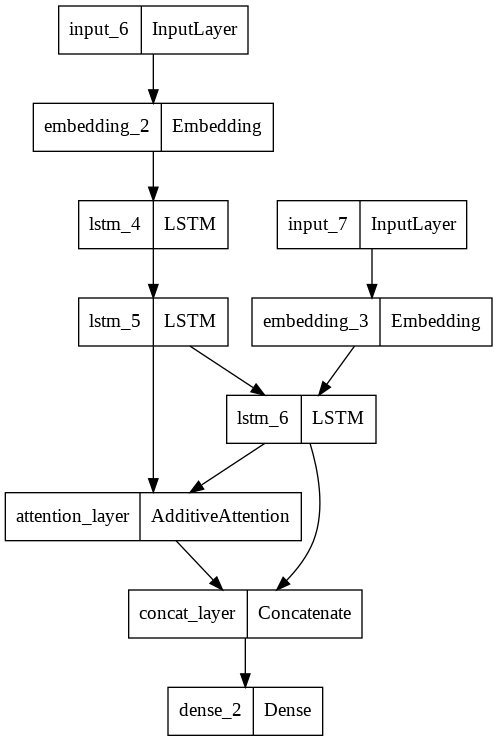

In [ ]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [ ]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 144s 452ms/step - loss: 5.3349 - accuracy: 0.3064 - val_loss: 4.7599 - val_accuracy: 0.3409
Epoch 2/50
300/300 [==============================] - 136s 452ms/step - loss: 4.4141 - accuracy: 0.3565 - val_loss: 4.0834 - val_accuracy: 0.3823
Epoch 3/50
300/300 [==============================] - 135s 451ms/step - loss: 3.7745 - accuracy: 0.3946 - val_loss: 3.7855 - val_accuracy: 0.4073
Epoch 4/50
300/300 [==============================] - 136s 453ms/step - loss: 3.3605 - accuracy: 0.4218 - val_loss: 3.6518 - val_accuracy: 0.4194
Epoch 5/50
300/300 [==============================] - 135s 451ms/step - loss: 3.0704 - accuracy: 0.4433 - val_loss: 3.5985 - val_accuracy: 0.4247
Epoch 6/50
300/300 [==============================] - 135s 449ms/step - loss: 2.8504 - accuracy: 0.4622 - val_loss: 3.5883 - val_accuracy: 0.4291
Epoch 7/50
300/300 [==============================] - 134s 446ms/step - loss: 2.6788 - accuracy: 0.4787 - val_loss: 3.6016 -

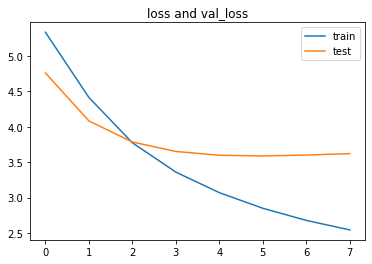

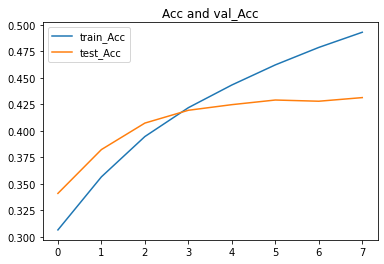

In [ ]:
# 시각화 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('loss and val_loss')
plt.show()

plt.plot(history.history['accuracy'], label = 'train_Acc')
plt.plot(history.history['val_accuracy'], label = 'test_Acc')
plt.legend()
plt.title('Acc and val_Acc')
plt.show()

이전의 모델에서는 val_loss가 3.6650 / val_accuracy가 0.4158로 나왔으나   
현재 모델은 val_loss가 3.6216 / val_accuracy가 0.4313으로  

loss값의 미세한 감소와 accuracy의 미세한 증가를 볼 수 있다.
다만 loss and val_loss 그래프를 보면 위 모델과 동일하게   
epoch이 증가할 수록 val_loss 값의 감소폭이 작아지는 것을 볼 수 있다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
# 테스트 데이터 10개의 샘플에 대해서 실제 요약과 예측돤 요약 비교
for i in range(60, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old man allegedly set wife ablaze mumbai pouring kerosene argument take hospital six days accused instead kept home took help local doctors treatment neighbours alerted family got admitted hospital 
실제 요약 : mumbai man sets wife on fire keeps her in home for days 
예측 요약 :  man who killed wife after being denied treatment


원문 : virat kohli earns crore every week ipl weekly salary expensive premier league player romelu lukaku belgian striker plays manchester united earns crore every week kohli weekly salary also recently added players arsenal alexandre chelsea morata 
실제 요약 : kohli earns more per week in ipl than pl latest transfers 
예측 요약 :  kohli has been expensive for crore ferguson


원문 : mukesh ambani led reliance industries signed agreement acquire us based telecom solutions provider corporation million cash acquisition jio global innovation technology leadership areas iot open source architecture adoption reliance jio director akash ambani said 
실제 요약 : ambani to acquire

val_accuracy가 증가해서 그런지는 몰라도   
실제요약과 예측요약의 비슷한 단어가 눈에 띄는 듯하다.  
다만. 해석을 해 보았을 떄, 서로 안 맞는 내용들이 많다.

----------
# 7. 전처리 재시작

---------
이전에는 최소한의 처리만 진행하였지만 이번에는 긴 문장을 조금 더 제외해보겠다.   
또한 길이가 짧은 단어는 모델이 학습하는데 유용할거라 생각하고 제외하지 않았지만  
인터넷 서칭을 통해 영어권 언어는 길이가 짧은 단어를 삭제하는 것만으로도  
어느 정도 자연어 처리에서 효과를 볼 수 있다는 내용을 보고 짧은 단어들도 같이 제외를 시켜보겠다.

In [21]:
# 정규화 및 불용어 처리한 데이터 부터 재시작
data2 = pd.DataFrame()
data2['Text'] = clean_text
data2['Summary'] = clean_summary


In [22]:
data2.head()

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


In [23]:

# 빈 값을 Null 값으로 변환
data2.replace('', np.nan, inplace=True)

In [24]:
data2.isnull().sum()

Text       0
Summary    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


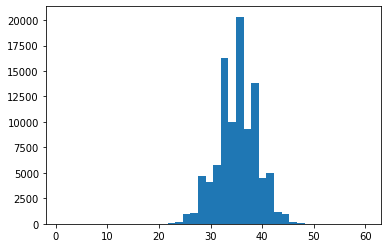

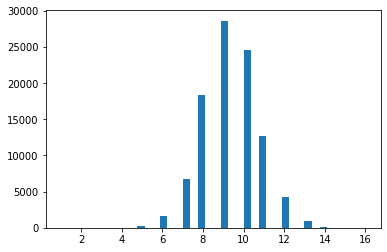

In [25]:
text_len2 = [len(s.split()) for s in data2['Text']]
summary_len2 = [len(s.split()) for s in data2['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len2)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len2)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len2)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len2)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len2)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len2)))


plt.hist(text_len2, bins = 40)
plt.show()
plt.hist(summary_len2, bins = 40)
plt.show()

In [26]:
# text와 summary의 최대길이를 임의로 설정
text_max_len_below= 38
summary_max_len_below = 11

text_max_len_above= 28
summary_max_len_above = 7

In [27]:
def below_threshold_len2(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [28]:
def above_threshold_len2(min_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= min_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %f'%(min_len, (cnt / len(nested_list))))

In [29]:
below_threshold_len2(text_max_len_below, data2['Text'])
below_threshold_len2(summary_max_len_below,  data2['Summary'])
print('='*50)
above_threshold_len2(text_max_len_above, data2['Text'])
above_threshold_len2(summary_max_len_above,  data2['Summary'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661
전체 샘플 중 길이가 28 이하인 샘플의 비율: 0.040911
전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.088715


text의 경우 길이가 28 ~ 38 사이의 길이만 남기고 전체의 약 20%를 제외하려한다.  
summary의 경우 길이가 7 ~ 11 사이의 길이만 남기고 전체의 약 7%를 제외하려 한다. 

In [30]:
len(data2)

98360

In [31]:
data2 = data2[data2['Text'].apply(lambda x: len(x.split()) <= text_max_len_below)]
data2 = data2[data2['Summary'].apply(lambda x: len(x.split()) <= summary_max_len_below)]
print('전체 샘플수 :', (len(data2)))

전체 샘플수 : 75754


In [32]:
data2 = data2[data2['Text'].apply(lambda x: len(x.split()) >= text_max_len_above)]
data2 = data2[data2['Summary'].apply(lambda x: len(x.split()) >= summary_max_len_above)]
print('전체 샘플수 :', (len(data2)))

전체 샘플수 : 72181


길이를 기준으로 데이터 제외 후 잘 처리 되었는지 확인

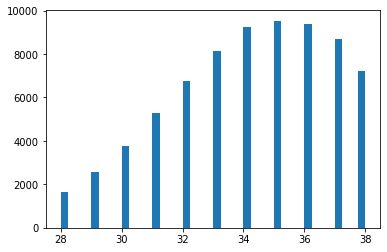

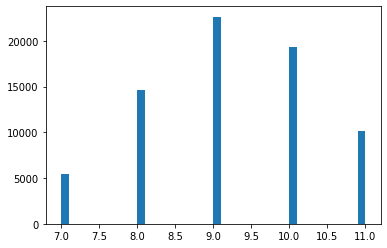

In [33]:
text_len2 = [len(s.split()) for s in data2['Text']]
summary_len2 = [len(s.split()) for s in data2['Summary']]

plt.hist(text_len2, bins = 40)
plt.show()
plt.hist(summary_len2, bins = 40)
plt.show()

In [34]:
# 시작과 종료 토큰 추가 
data2['decoder_input'] = data2['Summary'].apply(lambda x : 'sostoken '+ x)
data2['decoder_target'] = data2['Summary'].apply(lambda x : x + ' eostoken')
data2.head()

,Text,Summary,decoder_input,decoder_target
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll in rajasthan takes to...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...


In [35]:
# numpy타입으로 저장
encoder_input2 = np.array(data2['Text']) # 인코더의 입력
decoder_input2 = np.array(data2['decoder_input']) # 디코더의 입력
decoder_target2 = np.array(data2['decoder_target']) # 디코더의 레이블

In [36]:
indices2 = np.arange(encoder_input2.shape[0])
np.random.shuffle(indices2)
print(indices2)

[71926 26273   187 ... 19633 37169 37288]


In [37]:
# 데이터의 샘플 순서 재정의
encoder_input2 = encoder_input2[indices2]
decoder_input2 = decoder_input2[indices2]
decoder_target2 = decoder_target2[indices2]

In [38]:
# 데이터 8대2로 분리
n_of_val = int(len(encoder_input2)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14436


In [39]:
# 8대 2로 분리
encoder_input_train2 = encoder_input2[:-n_of_val]
decoder_input_train2 = decoder_input2[:-n_of_val]
decoder_target_train2 = decoder_target2[:-n_of_val]

encoder_input_test2 = encoder_input2[-n_of_val:]
decoder_input_test2 = decoder_input2[-n_of_val:]
decoder_target_test2 = decoder_target2[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train2))
print('훈련 레이블의 개수 :', len(decoder_input_train2))
print('테스트 데이터의 개수 :', len(encoder_input_test2))
print('테스트 레이블의 개수 :', len(decoder_input_test2))

훈련 데이터의 개수 : 57745
훈련 레이블의 개수 : 57745
테스트 데이터의 개수 : 14436
테스트 레이블의 개수 : 14436


In [40]:
src_tokenizer2 = Tokenizer() # 토크나이저 정의
src_tokenizer2.fit_on_texts(encoder_input_train2) # 입력된 데이터로부터 단어 집합 생성

# 이로 인해 단어의 집합은 src_tokenizer2.word_index에 저장되어 있음 

In [41]:
threshold = 8
total_cnt = len(src_tokenizer2.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer2.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 59001
등장 빈도가 7번 이하인 희귀 단어의 수: 41648
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17353
단어 집합에서 희귀 단어의 비율: 70.58863409094761
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.649680978910134


In [42]:
src_vocab2 = 16000
src_tokenizer2 = Tokenizer(num_words=src_vocab2) # 단어 집합의 크기 제한
src_tokenizer2.fit_on_texts(encoder_input_train2) # 단어 집합 재생성

In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train2 = src_tokenizer2.texts_to_sequences(encoder_input_train2) 
encoder_input_test2 = src_tokenizer2.texts_to_sequences(encoder_input_test2)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train2[:3])

[[284, 1757, 4891, 360, 7992, 1633, 1738, 271, 9699, 5006, 3823, 360, 1922, 989, 5113, 44, 171, 9196, 4700, 1575, 6222, 4849, 2462, 599, 16, 7010, 5006, 279, 4849, 3687], [125, 52, 1202, 7674, 1143, 673, 921, 5175, 1218, 1143, 6641, 134, 3824, 340, 1143, 483, 10, 2649, 929, 408, 1102, 3394, 97, 21, 623, 921, 119, 124, 1995, 2086], [79, 355, 522, 924, 69, 2, 12, 1089, 1406, 221, 841, 13824, 3557, 64, 5461, 582, 751, 1325, 8985, 5586, 4434, 808, 6, 69, 107, 2347, 1343, 129, 13824, 84, 1739, 961, 1041, 1008]]


In [44]:
# summary도 동일하게 수행
tar_tokenizer2 = Tokenizer()
tar_tokenizer2.fit_on_texts(decoder_input_train2)

In [45]:
threshold = 4
total_cnt = len(tar_tokenizer2.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer2.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26487
등장 빈도가 3번 이하인 희귀 단어의 수: 15212
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11275
단어 집합에서 희귀 단어의 비율: 57.43194774795183
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9158309486001546


In [46]:
tar_vocab2 = 10000
tar_tokenizer2 = Tokenizer(num_words=tar_vocab2) 
tar_tokenizer2.fit_on_texts(decoder_input_train2)
tar_tokenizer2.fit_on_texts(decoder_target_train2)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train2 = tar_tokenizer2.texts_to_sequences(decoder_input_train2) 
decoder_target_train2 = tar_tokenizer2.texts_to_sequences(decoder_target_train2)
decoder_input_test2 = tar_tokenizer2.texts_to_sequences(decoder_input_test2)
decoder_target_test2 = tar_tokenizer2.texts_to_sequences(decoder_target_test2)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train2[:5])
print('target')
print('decoder ',decoder_target_train2[:5])

input
input  [[1, 4213, 149, 5945, 3779, 14, 1399, 234], [1, 140, 3, 558, 431, 8856, 854, 5, 5601, 1804], [1, 2762, 1419, 172, 194, 4, 6355, 8, 2186], [1, 65, 6356, 186, 22, 5, 876, 59, 3, 5011, 9886], [1, 3626, 895, 152, 4788, 523, 232, 3780, 34, 462]]
target
decoder  [[4213, 149, 5945, 3779, 14, 1399, 234, 2], [140, 3, 558, 431, 8856, 854, 5, 5601, 1804, 2], [2762, 1419, 172, 194, 4, 6355, 8, 2186, 2], [65, 6356, 186, 22, 5, 876, 59, 3, 5011, 9886, 2], [3626, 895, 152, 4788, 523, 232, 3780, 34, 462, 2]]


In [47]:
drop_train2 = [index for index, sentence in enumerate(decoder_input_train2) if len(sentence) == 1]
drop_test2 = [index for index, sentence in enumerate(decoder_input_test2) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train2))
print('삭제할 테스트 데이터의 개수 :', len(drop_test2))

encoder_input_train2 = [sentence for index, sentence in enumerate(encoder_input_train2) if index not in drop_train2]
decoder_input_train2 = [sentence for index, sentence in enumerate(decoder_input_train2) if index not in drop_train2]
decoder_target_train2 = [sentence for index, sentence in enumerate(decoder_target_train2) if index not in drop_train2]

encoder_input_test2 = [sentence for index, sentence in enumerate(encoder_input_test2) if index not in drop_test2]
decoder_input_test2 = [sentence for index, sentence in enumerate(decoder_input_test2) if index not in drop_test2]
decoder_target_test2 = [sentence for index, sentence in enumerate(decoder_target_test2) if index not in drop_test2]

print('훈련 데이터의 개수 :', len(encoder_input_train2))
print('훈련 레이블의 개수 :', len(decoder_input_train2))
print('테스트 데이터의 개수 :', len(encoder_input_test2))
print('테스트 레이블의 개수 :', len(decoder_input_test2))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 57745
훈련 레이블의 개수 : 57745
테스트 데이터의 개수 : 14436
테스트 레이블의 개수 : 14436


패딩의 종류도 'pre'로 설정하려한다.  
왜냐하면 앞단에 0이 채워져 마지막 단어로 제로 패딩이 입력으로 들어가는 일 없이 올바른 시퀀스 모델링이 진행된다고 하기 때문이다.



In [48]:
encoder_input_train2 = pad_sequences(encoder_input_train2, maxlen=text_max_len_below, padding='pre')
encoder_input_test2 = pad_sequences(encoder_input_test2, maxlen=text_max_len_below, padding='pre')
decoder_input_train2 = pad_sequences(decoder_input_train2, maxlen=summary_max_len_below, padding='pre')
decoder_target_train2 = pad_sequences(decoder_target_train2, maxlen=summary_max_len_below, padding='pre')
decoder_input_test2 = pad_sequences(decoder_input_test2, maxlen=summary_max_len_below, padding='pre')
decoder_target_test2 = pad_sequences(decoder_target_test2, maxlen=summary_max_len_below, padding='pre')

---------
# 8. 모델 다시 설계하기

---------


전처리를 통해 입력데이터를 다수 삭제한 상황에서
위 모델과 동일하게 인코딩에 LSTM2개, 디코딩에 LSTM1개, Dense층 1개로 구성된 모델로 학습시켜보겠다.

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs2 = Input(shape=(text_max_len_below,))

# 인코더의 임베딩 층
enc2_emb = Embedding(src_vocab2, embedding_dim)(encoder_inputs2)

# 인코더의 LSTM 1
encoder2_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.1, recurrent_dropout = 0.2)
encoder2_output1, state2_h, state2_c = encoder2_lstm1(enc2_emb)

# 인코더의 LSTM 2
encoder2_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.2)
encoder2_output2, state2_h2, state2_c2 = encoder2_lstm2(encoder2_output1)


In [50]:
# 디코더 설계
decoder_inputs2 = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer2 = Embedding(tar_vocab2, embedding_dim)
dec_emb2 = dec_emb_layer2(decoder_inputs2)

# 디코더의 LSTM
decoder2_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder2_outputs, de_state_h, de_state_c = decoder2_lstm(dec_emb2,initial_state=[state2_h2, state2_c2])

In [51]:
from tensorflow.keras.layers import AdditiveAttention
# 어텐션 층(어텐션 함수)
attn_layer2 = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out2 = attn_layer2([decoder2_outputs, encoder2_output2])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input2 = Concatenate(axis=-1, name='concat_layer')([decoder2_outputs, attn_out2])

# 디코더의 출력층
decoder_softmax_layer2 = Dense(tar_vocab2, activation='softmax')
decoder_softmax_outputs2 = decoder_softmax_layer2(decoder_concat_input2)

# 모델 정의
model2 = Model([encoder_inputs2, decoder_inputs2], decoder_softmax_outputs2)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 128)      2048000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 38, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                 

모델의 형태 그래프를 통한 시각화

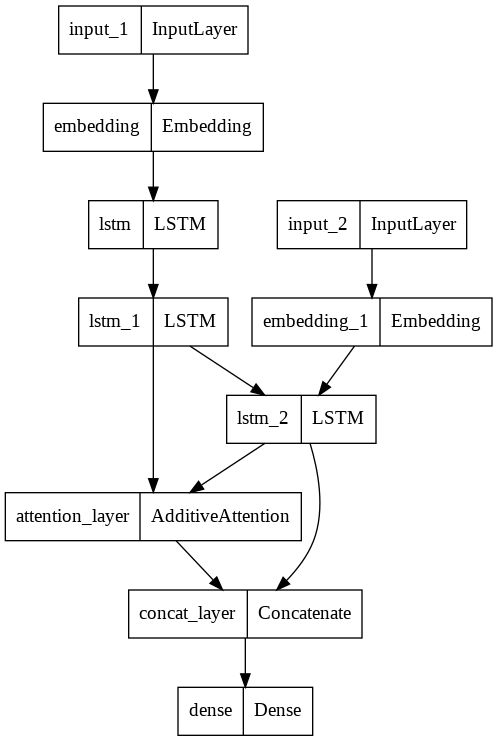

In [52]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [53]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history2 = model2.fit(x=[encoder_input_train2, decoder_input_train2], y=decoder_target_train2, \
          validation_data=([encoder_input_test2, decoder_input_test2], decoder_target_test2), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
226/226 [==============================] - 74s 281ms/step - loss: 6.1675 - accuracy: 0.2378 - val_loss: 5.6645 - val_accuracy: 0.2628
Epoch 2/50
226/226 [==============================] - 63s 278ms/step - loss: 5.6542 - accuracy: 0.2577 - val_loss: 5.5091 - val_accuracy: 0.2703
Epoch 3/50
226/226 [==============================] - 63s 277ms/step - loss: 5.4659 - accuracy: 0.2679 - val_loss: 5.3331 - val_accuracy: 0.2828
Epoch 4/50
226/226 [==============================] - 63s 277ms/step - loss: 5.2769 - accuracy: 0.2790 - val_loss: 5.1949 - val_accuracy: 0.2926
Epoch 5/50
226/226 [==============================] - 63s 277ms/step - loss: 5.1169 - accuracy: 0.2887 - val_loss: 5.1374 - val_accuracy: 0.2973
Epoch 6/50
226/226 [==============================] - 62s 276ms/step - loss: 4.8787 - accuracy: 0.3004 - val_loss: 4.8191 - val_accuracy: 0.3126
Epoch 7/50
226/226 [==============================] - 63s 277ms/step - loss: 4.5841 - accuracy: 0.3160 - val_loss: 4.5792 - val_ac

길이를 기준으로 데이터 제외를 최소한으로 했을 때에는 val_loss가 3.6216 / val_accuracy가 0.4313값을 가졌으나  
현재 전처리를 진행 한 후에는 val_loss가 3.9332 / val_accuracy 0.3870로 이전보다 수치상으로는 안 좋게나왔다.

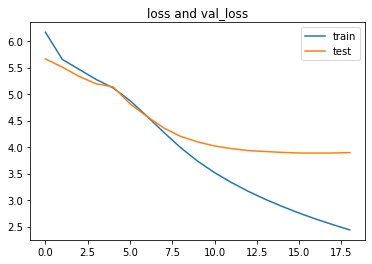

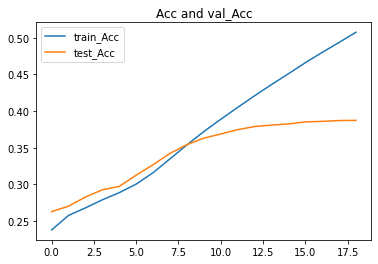

In [61]:
# 시각화 
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.title('loss and val_loss')
plt.show()

plt.plot(history2.history['accuracy'], label = 'train_Acc')
plt.plot(history2.history['val_accuracy'], label = 'test_Acc')
plt.legend()
plt.title('Acc and val_Acc')
plt.show()

다만, 그래프를 보면 loss값 기준 test값과 train값 모두 우하향하는 모습을 보이고 있어, 이전 보다는 과적합이 줄어든것 같다.

In [55]:
src_index_to_word2 = src_tokenizer2.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index2 = tar_tokenizer2.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word2 = tar_tokenizer2.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [56]:
# 인코더 설계
encoder_model2 = Model(inputs=encoder_inputs2, outputs=[encoder2_output2, state2_h2, state2_c2])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h2 = Input(shape=(hidden_size,))
decoder_state_input_c2 = Input(shape=(hidden_size,))

dec2_emb2 = dec_emb_layer2(decoder_inputs2)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder2_outputs2, state2_h, state2_c = decoder2_lstm(dec2_emb2, initial_state=[decoder_state_input_h2, decoder_state_input_c2])

In [57]:
# 어텐션 함수
decoder_hidden_state_input2 = Input(shape=(text_max_len_below, hidden_size))
attn_out_inf2 = attn_layer2([decoder2_outputs2, decoder_hidden_state_input2])
decoder_inf_concat2 = Concatenate(axis=-1, name='concat')([decoder2_outputs2, attn_out_inf2])

# 디코더의 출력층
decoder2_outputs2 = decoder_softmax_layer2(decoder_inf_concat2) 

# 최종 디코더 모델
decoder_model2 = Model(
    [decoder_inputs2] + [decoder_hidden_state_input2,decoder_state_input_h2, decoder_state_input_c2],
    [decoder2_outputs2] + [state2_h, state2_c])

In [58]:
def decode_sequence2(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model2.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index2['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model2.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word2[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len_below-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text2(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word2[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary2(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index2['sostoken']) and i!=tar_word_to_index2['eostoken']):
            temp = temp + tar_index_to_word2[i] + ' '
    return temp

In [60]:
# 테스트 데이터 10개의 샘플에 대해서 실제 요약과 예측돤 요약 비교
for i in range(70, 80):
    print("원문 :", seq2text2(encoder_input_test2[i]))
    print("실제 요약 :", seq2summary2(decoder_input_test2[i]))
    print("예측 요약 :", decode_sequence2(encoder_input_test2[i].reshape(1, text_max_len_below)))
    print("\n")

원문 : day one second test india england lord abandoned without even ball bowled due rain former indian cricketer sachin tendulkar supposed ring lord bell start play india trailing series suffering run defeat edgbaston 
실제 요약 : day one of lord test abandoned without ball being bowled 
예측 요약 :  batsmen have been abandoned due to test test test selectors


원문 : fifty six indigo staffers went strike varanasi airport today due alleged delay salaries reportedly sat garden airport protested airline meanwhile airport director said facing problems varanasi airport dealing indigo passengers indigo staff given notice airports authority india 
실제 요약 : over indigo go on strike at varanasi airport 
예측 요약 :  indigo to deploy airlines to deploy airlines to end flights


원문 : trailer baaghi starring tiger shroff rumoured girlfriend disha patani released film sequel action film baaghi starred tiger along shraddha kapoor directed choreographer turned filmmaker ahmed khan produced sajid nadiadwala baaghi s

요약문을 추출하는 것 역시 이전보다는 문맥이 이상한것 같다.

--------
## Dense Layer 추가
Exp6때, Dense layer를 추가했을 때 loss값이 감소했던 경험을 활용해 
동일한 모델에 Dense Layer를 추가하고 활성화 함수로 자연어 처리에 많이 사용되는 'tanh'를 사용해 결과를 비교해보려한다.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs2 = Input(shape=(text_max_len_below,))
# 인코더의 임베딩 층
enc2_emb = Embedding(src_vocab2, embedding_dim)(encoder_inputs2)

# 인코더의 LSTM 1
encoder2_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder2_output1, state2_h, state2_c = encoder2_lstm1(enc2_emb)

# 인코더의 LSTM 2
encoder2_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder2_output2, state2_h2, state2_c2 = encoder2_lstm2(encoder2_output1)

# --------------------------------------------------------------------------------

# 디코더 설계
decoder_inputs2 = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer2 = Embedding(tar_vocab2, embedding_dim)
dec_emb2 = dec_emb_layer2(decoder_inputs2)

# 디코더의 LSTM
decoder2_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder2_outputs, de_state_h, de_state_c = decoder2_lstm(dec_emb2,initial_state=[state2_h2, state2_c2])

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer2 = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out2 = attn_layer2([decoder2_outputs, encoder2_output2])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input2 = Concatenate(axis=-1, name='concat_layer')([decoder2_outputs, attn_out2])

# 디코더의 출력층
decoder_tanh_layer = Dense(512, activation='tanh')
decoder_tanh_outputs = decoder_tanh_layer(decoder_concat_input2)
decoder_softmax_layer2 = Dense(tar_vocab2, activation='softmax')
decoder_softmax_outputs2 = decoder_softmax_layer2(decoder_tanh_outputs)

# 모델 정의
model2 = Model([encoder_inputs2, decoder_inputs2], decoder_softmax_outputs2)
model2.summary()



Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 38)]         0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 38, 128)      2048000     ['input_43[0][0]']               
                                                                                                  
 input_44 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 lstm_28 (LSTM)                 [(None, 38, 256),    394240      ['embedding_18[0][0]']           
                                 (None, 256),                                              

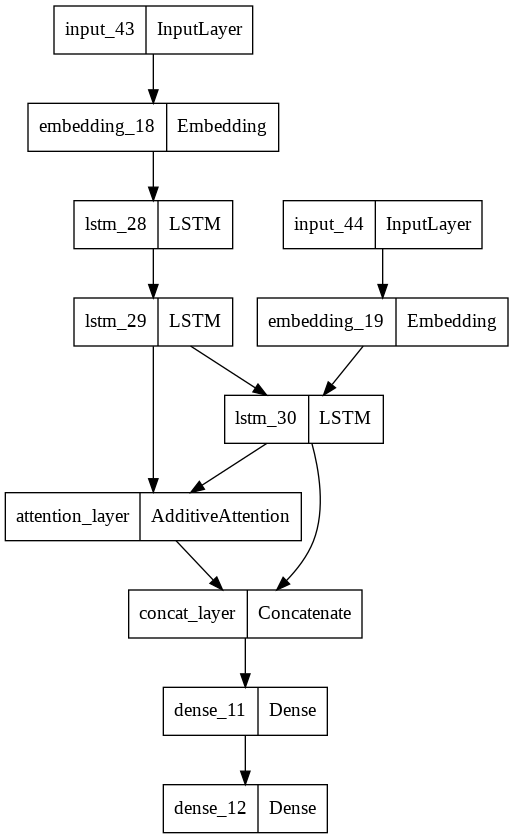

In [ ]:
from tensorflow.keras.utils import plot_model
tensorflow.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [ ]:
from tensorflow.keras import optimizers
import keras
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history2 = model2.fit(x=[encoder_input_train2, decoder_input_train2], y=decoder_target_train2, \
          validation_data=([encoder_input_test2, decoder_input_test2], decoder_target_test2), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
226/226 [==============================] - 114s 459ms/step - loss: 6.2348 - accuracy: 0.2379 - val_loss: 5.8109 - val_accuracy: 0.2646
Epoch 2/50
226/226 [==============================] - 103s 454ms/step - loss: 5.7155 - accuracy: 0.2600 - val_loss: 5.4521 - val_accuracy: 0.2760
Epoch 3/50
226/226 [==============================] - 102s 451ms/step - loss: 5.4204 - accuracy: 0.2737 - val_loss: 5.2715 - val_accuracy: 0.2896
Epoch 4/50
226/226 [==============================] - 102s 449ms/step - loss: 5.1753 - accuracy: 0.2870 - val_loss: 5.0210 - val_accuracy: 0.3011
Epoch 5/50
226/226 [==============================] - 102s 450ms/step - loss: 4.8749 - accuracy: 0.3012 - val_loss: 4.7578 - val_accuracy: 0.3161
Epoch 6/50
226/226 [==============================] - 101s 448ms/step - loss: 4.5608 - accuracy: 0.3179 - val_loss: 4.5488 - val_accuracy: 0.3290
Epoch 7/50
226/226 [==============================] - 101s 448ms/step - loss: 4.3146 - accuracy: 0.3324 - val_loss: 4.4000 -

dense를 추가한 결과 loss값과 Accuracy값이 더 좋아졌으나 결과적으로 전처리를 최소화한 모델의 성능보다는 좋지않게 나왔다.

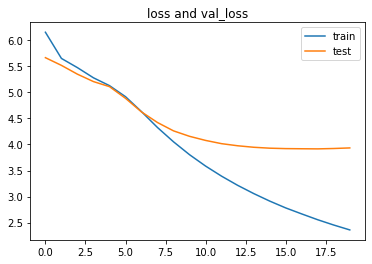

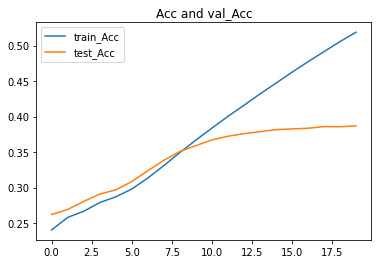

In [ ]:
# 시각화 
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.title('loss and val_loss')
plt.show()

plt.plot(history2.history['accuracy'], label = 'train_Acc')
plt.plot(history2.history['val_accuracy'], label = 'test_Acc')
plt.legend()
plt.title('Acc and val_Acc')
plt.show()

In [ ]:
src_index_to_word2 = src_tokenizer2.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index2 = tar_tokenizer2.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word2 = tar_tokenizer2.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model2 = Model(inputs=encoder_inputs2, outputs=[encoder2_output2, state2_h2, state2_c2])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h2 = Input(shape=(hidden_size,))
decoder_state_input_c2 = Input(shape=(hidden_size,))

dec2_emb2 = dec_emb_layer2(decoder_inputs2)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder2_outputs2, state2_h, state2_c = decoder2_lstm(dec2_emb2, initial_state=[decoder_state_input_h2, decoder_state_input_c2])

# 어텐션 함수
decoder_hidden_state_input2 = Input(shape=(text_max_len_below, hidden_size))
attn_out_inf2 = attn_layer2([decoder2_outputs2, decoder_hidden_state_input2])
decoder_inf_concat2 = Concatenate(axis=-1, name='concat')([decoder2_outputs2, attn_out_inf2])

# 디코더의 출력층
decoder2_outputs2 = decoder_softmax_layer2(decoder_inf_concat2) 

# 최종 디코더 모델
decoder_model2 = Model(
    [decoder_inputs2] + [decoder_hidden_state_input2,decoder_state_input_h2, decoder_state_input_c2],
    [decoder2_outputs2] + [state2_h, state2_c])

In [ ]:
def decode_sequence2(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model2.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index2['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model2.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word2[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len_below-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text2(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word2[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary2(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index2['sostoken']) and i!=tar_word_to_index2['eostoken']):
            temp = temp + tar_index_to_word2[i] + ' '
    return temp

In [ ]:
# 테스트 데이터 10개의 샘플에 대해서 실제 요약과 예측돤 요약 비교
for i in range(80, 90):
    print("원문 :", seq2text2(encoder_input_test2[i]))
    print("실제 요약 :", seq2summary2(decoder_input_test2[i]))
    print("예측 요약 :", decode_sequence2(encoder_input_test2[i].reshape(1, text_max_len_below)))
    print("\n")

원문 : sullivan tour de yorkshire race volunteer narrowly avoided accident running right seconds team support car bikes crashed traffic island standing volunteer later said sheer luck car missed race organisers investigating matter 
실제 요약 : race avoids car that goes on to crash 
예측 요약 :  commission unemployment rawat open rawat conference min conference rawat rifles


원문 : delhi police personnel formed human chain rescue couple trapped building central delhi fire broke wednesday two cops reached balcony second floor made human chain reach rescue woman fall husband also rescued similarly 
실제 요약 : delhi cops form human chain to save couple trapped in fire 
예측 요약 :  pay record pictures pictures board board board board ivory ivory


원문 : karnataka governor vajubhai vala opened official residence raj bhavan public viewing august august built british army officer acre colonial building rooms named different indian rivers mountains raj bhavan opened public pm pm 
실제 요약 : karnataka governor open

전처리 과정에서 너무 많은 문장을 제외했거나, 짧은 문장을 제외하는 것이 성능에 악영향을 준것 같다.
전처리의 중요성을 다시금 느낄 수 있었다.

------
# 9. 추출적 요약
------

In [63]:
# 데이터 다운로드 하기 
import requests
from summa.summarizer import summarize

In [64]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
extra = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [65]:
# 확인
extra.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [66]:
for idx, (head, text) in enumerate(zip(extra['headlines'], extra['text'])):
    if idx == 20:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.4))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

In [67]:
for idx, (head, text) in enumerate(zip(extra['headlines'], extra['text'])):
    if idx == 20:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, words=30))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit

추출적 요약에서 ratio 또는 Word를 낮은 값으로 설정했을 때, 문장을 추출하지 못하고 공란으로 나오는 경우가 있었다.   
해당 부분은 함수 자체적으로 요약한 글자가 내가 제한한 수보다 넘으면 공란으로 나오는 것 같다.  

추출적 요약의 경우 간단한 함수를 통해 요약은 가능하나 짧은 단어로의 요약은 어려워 보이며, 문법적 요류가 종종 보인다.

------
# 10. 회고
___________

- 여러가지 값을 바꿔가며 loss값 혹은 accuracy값을 확인해보고 싶었지만 하이퍼파라민터 값이 높을 수록 시간이 오래걸린다. 모델을 돌려놓고 다른 일을 할 수도 있지만 colab의 런타임이 끊기면서 다시 시작하는 경우가 종종 있었다. 기다리는 것이 힘들었고 그로인해, 더 많은 시도를 못해본 것에 대해서 아쉬움이 남는다. 

- 텍스트 요약의 경우 시간은 오래걸리지만 짧은 문장 또는 핵심 문장으로 요약을 해줘 추출적 요약보다는 상대적 완성도는 있으나 핵심 내용이 아닌 경우의 빈도가 더 많으며, 헛소리를 하는 경우도 종종 보았다.

- 추출적 요약의 경우 함수 하나만 쓰면 간단하나 핵심 단어를 뽑아내지 못하고 주저리주저리 하는 듯한 느낌을 받았다. 또한 ratio or word와 같은 파라미터를 사용해 글자수에 제한을 적게 주면 문장을 생성하지 못하는 큰 단점이 있다고 느겼다.

- 기계에게 인간처럼 문장을 요약하라고 시키는 부분에 대한 어려움을 느꼈고, 이번 회차를 통해 attention에 대해 얇게 알 수 있었으며, attention의 문제를 개선한 모델인 transfomer와 Bert에 대해서 알게 되었다. 추후 bert를 활용하는 회차가 있다고 들었는데 해당 회차에서 bert의 성능에 대해서 확인해 보고 싶어졌다.

- 매번 회차가 끝나고 느끼지만 전처리를 조금 더 세세하고 공을 들였으면하는 아쉬움이 남는다. 